In [1]:
import json
from pathlib import Path
from collections import Counter

import numpy as np
from nnunetv2.training.dataloading.base_data_loader import nnUNetDataLoaderBase
from nnunetv2.training.dataloading.nnunet_dataset import nnUNetDataset
from nnunetv2.training.dataloading.utils import build_sampling_probabilities

In [2]:
class nnUNetDataLoader3D(nnUNetDataLoaderBase):
    def generate_train_batch(self):
        selected_keys = self.get_indices()
        # preallocate memory for data and seg
        data_all = np.zeros(self.data_shape, dtype=np.float32)
        seg_all = np.zeros(self.seg_shape, dtype=np.int16)
        case_properties = []
        positives = []

        for j, i in enumerate(selected_keys):
            # oversampling foreground will improve stability of model training, especially if many patches are empty
            # (Lung for example)
            force_fg = self.get_do_oversample(j)

            data, seg, properties = self._data.load_case(i)
            lesion_all = np.sum(seg)

            # If we are doing the cascade then the segmentation from the previous stage will already have been loaded by
            # self._data.load_case(i) (see nnUNetDataset.load_case)
            shape = data.shape[1:]
            dim = len(shape)
            bbox_lbs, bbox_ubs = self.get_bbox(shape, force_fg, properties['class_locations'], properties['vessel_locations'])

            # whoever wrote this knew what he was doing (hint: it was me). We first crop the data to the region of the
            # bbox that actually lies within the data. This will result in a smaller array which is then faster to pad.
            # valid_bbox is just the coord that lied within the data cube. It will be padded to match the patch size
            # later
            valid_bbox_lbs = [max(0, bbox_lbs[i]) for i in range(dim)]
            valid_bbox_ubs = [min(shape[i], bbox_ubs[i]) for i in range(dim)]

            # At this point you might ask yourself why we would treat seg differently from seg_from_previous_stage.
            # Why not just concatenate them here and forget about the if statements? Well that's because segneeds to
            # be padded with -1 constant whereas seg_from_previous_stage needs to be padded with 0s (we could also
            # remove label -1 in the data augmentation but this way it is less error prone)
            this_slice = tuple([slice(0, data.shape[0])] + [slice(i, j) for i, j in zip(valid_bbox_lbs, valid_bbox_ubs)])
            data = data[this_slice]

            this_slice = tuple([slice(0, seg.shape[0])] + [slice(i, j) for i, j in zip(valid_bbox_lbs, valid_bbox_ubs)])
            seg = seg[this_slice]

            padding = [(-min(0, bbox_lbs[i]), max(bbox_ubs[i] - shape[i], 0)) for i in range(dim)]
            data_all[j] = np.pad(data, ((0, 0), *padding), 'constant', constant_values=0)
            seg_all[j] = np.pad(seg, ((0, 0), *padding), 'constant', constant_values=-1)
            lesion_patch = np.sum(seg_all[j]) #data: (10, 1, 16, 32, 32)
            c_i, z_i, y_i, x_i = np.where(seg_all[j] > 0)
            if len(z_i) > 0:
                z_long = np.max(z_i) - np.min(z_i)
                y_long = np.max(y_i) - np.min(y_i)
                x_long = np.max(x_i) - np.min(x_i)

                #正樣本條件判斷
                if lesion_patch >= lesion_all:
                    positive = 1
                elif z_long >= self.data_shape[1]:
                    positive = 1
                elif y_long >= self.data_shape[2] and x_long >= self.data_shape[3]*0.6:
                    positive = 1
                elif y_long >= self.data_shape[2]/2 and x_long >= self.data_shape[3]*0.6:
                    positive = 1
                else:
                    positive = 0
            else:
                positive = 0
            positives.append(int(positive))

        return {'data': data_all, 'seg': seg_all, 'properties': case_properties, 'positives': positives, 'keys': selected_keys}

In [3]:
dataset_json = {
  "TASK": "DeepAneurysm",
  "No.": "137",
  "channel_names": {
    "0": "MRA_BRAIN"
  },
  "labels": {
    "background": 0,
    "Aneurysm": 1
  },
  "numTraining": 3059,
  "file_ending": ".nii.gz",
  "val_as_test": "n"
}

In [4]:
from nnunetv2.utilities.plans_handling.plans_handler import PlansManager, ConfigurationManager

plans_manager = PlansManager(dataset_json)
#configuration_manager = plans_manager.get_configuration('3d_fullres')
label_manager = plans_manager.get_label_manager(dataset_json)

print('label_manager:', vars(label_manager))
print('label_manager.has_regions:', label_manager.has_regions)
print('label_manager.ignore_label:', label_manager.ignore_label)
print('label_manager.foreground_labels:', label_manager.foreground_labels)

No label manager specified in plans. Using default: LabelManager
label_manager: {'label_dict': {'background': 0, 'Aneurysm': 1}, 'regions_class_order': None, '_force_use_labels': False, '_has_regions': False, '_ignore_label': None, '_all_labels': [0, 1], '_regions': None, 'inference_nonlin': <function softmax_helper_dim0 at 0x7f9ffc0c3280>}
label_manager.has_regions: False
label_manager.ignore_label: None
label_manager.foreground_labels: [1]


In [5]:
case_list = [
      "DeepAneurysm_000001",
      "DeepAneurysm_000002",
      "DeepAneurysm_000003",
      "DeepAneurysm_000004",
      "DeepAneurysm_000005",
      "DeepAneurysm_000006",
      "DeepAneurysm_000007"]

case_list = [
      "DeepAneurysm_000001",
      "DeepAneurysm_000002",
      "DeepAneurysm_000004",
      "DeepAneurysm_000005",
      "DeepAneurysm_000006",
      "DeepAneurysm_000007"]

sampling_categories = {
    "DeepAneurysm_000001": 1,
    "DeepAneurysm_000002": 2,
    "DeepAneurysm_000004": 1,
    "DeepAneurysm_000005": 1,
    "DeepAneurysm_000006": 2,
    "DeepAneurysm_000007": 1,
    }

In [31]:
# 依 nnUNetTrainer.py（血管4分類）同款的加權抽樣設定
SAMPLING_CATEGORY_WEIGHTS = {1: 1, 2: 1, 3: 1, 4: 1}

folder = '/home/chuan/nnUNet_testdata/nnUNet_preprocessed/Dataset137_DeepAneurysm/nnUNetPlans_3d_fullres'
ds = nnUNetDataset(folder, case_list)  # this should not load the properties!
tr_keys = list(ds.keys())

# trainer 會從 preprocessed dataset base 的 splits_final.json 載入 sampling_categories
# 支援新格式：{"splits": [...], "sampling_categories": {case_id: 1~4}}
splits_file = Path(folder).parent / 'splits_final.json'
sampling_categories = None
if splits_file.exists():
    with open(splits_file, 'r', encoding='utf-8') as f:
        split_data = json.load(f)
    if isinstance(split_data, dict):
        sampling_categories = split_data.get('sampling_categories')

sampling_probabilities = build_sampling_probabilities(
    tr_keys,
    sampling_categories=sampling_categories,
    category_weights=SAMPLING_CATEGORY_WEIGHTS,
    mode='target_proportion',
)

if sampling_probabilities is None:
    print('sampling_probabilities: None（splits_final.json 未提供 sampling_categories 或未啟用加權）')
else:
    subset_counts = Counter(sampling_categories.get(k, 1) for k in tr_keys) if sampling_categories else Counter()
    print('sampling_probabilities enabled. subset category counts:', dict(sorted(subset_counts.items())))
    print('sampling_probabilities sum:', float(np.sum(sampling_probabilities)))

    expected_mass = {}
    for k, p in zip(tr_keys, sampling_probabilities):
        c = sampling_categories.get(k, 1) if sampling_categories else 1
        expected_mass[c] = expected_mass.get(c, 0.0) + float(p)
    expected_ids = sorted(set(expected_mass.keys()) | {1, 2, 3, 4})
    expected_pct = {c: expected_mass.get(c, 0.0) for c in expected_ids}
    print('corrected expected sampling proportions (by category):', expected_pct)

# 把 sampling_probabilities 傳給 dataloader，get_indices() 會依機率抽樣 case keys
dl = nnUNetDataLoader3D(ds, 10, (16, 32, 32), (16, 32, 32), label_manager, 1, sampling_probabilities, None)
a = next(dl)
print('len(a):', len(a))
print('data:', a['data'].shape)
print('seg:', a['seg'].shape)
print('properties:', a['properties'])
print('positives:', a['positives'])
print('keys:', a['keys'].shape)

for key in a['keys']:
    print(key)

sampling_probabilities enabled. subset category counts: {1: 4, 2: 2}
sampling_probabilities sum: 1.0
corrected expected sampling proportions (by category): {1: 0.5, 2: 0.5, 3: 0.0, 4: 0.0}
len(a): 5
data: (10, 1, 16, 32, 32)
seg: (10, 1, 16, 32, 32)
properties: []
positives: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
keys: (10,)
DeepAneurysm_000005
DeepAneurysm_000004
DeepAneurysm_000002
DeepAneurysm_000001
DeepAneurysm_000006
DeepAneurysm_000006
DeepAneurysm_000004
DeepAneurysm_000006
DeepAneurysm_000006
DeepAneurysm_000001


In [32]:
sampling_probabilities

array([0.125, 0.25 , 0.125, 0.125, 0.25 , 0.125])

In [8]:
#data是訓練的資料，data: torch.Size([600, 1, 16, 32, 32])
#target因為deep supervision，所以為一個list有4層，這邊取第一層與label對在一起看

In [9]:
from scipy import ndimage, interp  # pip install scipy
import scipy.stats
from sklearn.model_selection import train_test_split  # pip install scikit-learn
from sklearn.utils import class_weight
from sklearn.metrics import roc_curve, auc, confusion_matrix, classification_report, f1_score, cohen_kappa_score
from skimage.util import montage  # pip install scikit-image
import skimage
import pickle
import cv2
import csv
import math
import datetime
from itertools import zip_longest
import json
import random
import numpy as np
import matplotlib
#%matplotlib notebook
%matplotlib inline
#matplotlib.use('Agg') 
import matplotlib.pyplot as plt

In [10]:
def plot_multi_view(img, label):
    #先決定影像是否為正規化後，是的話就不用再做正規化, 先決定影像是否為4d，畫三張，原圖,label,疊圖
    #dim=3為標註123放在一起，dim=4為一標註一層，統一把標註轉為1層1個吧
    # 生成 1 到 100 之間的隨機正整數（包括 1 和 100）
    random_integer = random.randint(0, img.shape[0]-1)
    sample = img[random_integer,0,:,:,:]
    targe = label[random_integer,0,:,:,:]
    
    #為了展示正規化
    sample = (((sample - np.min(sample))/(np.max(sample) - np.min(sample)))*255).copy()
    sample[sample<0] = 0
    sample[sample>255] = 255
    #rands = np.random.randint(0, img.shape[-1], num) #multi view
    for idx in range(sample.shape[0]):
        show = np.expand_dims(sample[idx,:,:], axis=-1).copy()
        y_i, x_i, z_i = show.shape
        show_one = show.copy()
        show = np.concatenate([show, show_one],2)
        show = np.concatenate([show, show_one],2)
        show = show.astype('uint8')
        show_label = np.zeros((y_i, x_i)).astype('uint8')
        show_IL = show.copy()

        y_nor1 = targe[idx,:,:]    
        y_color = (y_nor1*255).astype('uint8')
        y_th = cv2.Canny(y_color, 128, 256).copy()
        y_th = y_th.astype('uint8')

        y_c, x_c = np.where(y_nor1>0)
        if len(y_c) > 0:    
            show_label[y_c,x_c] = 1
        y_c, x_c = np.where(y_th>0)
        if len(y_c) > 0:    
            show_IL[y_c,x_c,0] = 255
            show_IL[y_c,x_c,1] = 0
            show_IL[y_c,x_c,2] = 0
                
        plt.style.use('default') #使用背景色，繪圖風格
        plt.figure(figsize=(20, 20)) #show 2view
        plt.subplot(1,3,1)
        plt.imshow(show)
        plt.title('Image', fontsize=20)
        plt.axis('off')
        plt.subplot(1,3,2)
        plt.imshow(show_label, cmap='bone')
        plt.title('Label', fontsize=20)
        plt.axis('off')
        plt.subplot(1,3,3)
        plt.imshow(show_IL)
        plt.title('ImgLabel', fontsize=20)
        plt.axis('off')        
        plt.show()

In [11]:
def set_right(img):
    img = np.transpose(img, (1, 2, 0))
    img = np.flip(img,0)
    img = np.flip(img,1)
    img = np.flip(img,-1)
    return img

def easy_nor(sample):
    sample = (((sample - np.min(sample))/(np.max(sample) - np.min(sample)))*255).copy()
    sample[sample<0] = 0
    sample[sample>255] = 255
    return sample

def easy_show(sample, idx):
    show = np.expand_dims(sample[:,:,idx], axis=-1).copy()
    #print(show.shape)
    y_i, x_i, z_i = show.shape
    show_one = show.copy()
    show = np.concatenate([show, show_one],2)
    show = np.concatenate([show, show_one],2)
    show = show.astype('uint8')
    return show

def esay_canny(targe, idx):
    y_nor1 = targe[:,:,idx]    
    y_color = (y_nor1*255).astype('uint8')
    y_th = cv2.Canny(y_color, 128, 256).copy()
    y_th = y_th.astype('uint8')
    return y_th

def plot_multi_view2(img1, label1, img2, label2, random_integer):
    #先決定影像是否為正規化後，是的話就不用再做正規化, 先決定影像是否為4d，畫三張，原圖,label,疊圖
    #dim=3為標註123放在一起，dim=4為一標註一層，統一把標註轉為1層1個吧
    # 生成 1 到 100 之間的隨機正整數（包括 1 和 100） => 改成指定
    #random_integer = random.randint(0, img1.shape[0]-1)
    sample1 = img1[random_integer,0,:,:,:]
    targe1 = label1[random_integer,0,:,:,:]
    sample2 = img2[random_integer,0,:,:,:]
    targe2 = label2[random_integer,0,:,:,:]
    
    sample1 = set_right(sample1)
    targe1 = set_right(targe1)
    sample2 = set_right(sample2)
    targe2 = set_right(targe2)

    #為了展示正規化
    sample1 = easy_nor(sample1)
    sample2 = easy_nor(sample2)
    
    for idx in range(sample1.shape[-1]):
        show1 = easy_show(sample1, idx)
        show_IL1 = show1.copy()
        show2 = easy_show(sample2, idx)
        show_IL2 = show2.copy()
        
        y_th1 = esay_canny(targe1, idx)
        y_th2 = esay_canny(targe2, idx)

        y_c, x_c = np.where(y_th1>0)
        if len(y_c) > 0:    
            show_IL1[y_c,x_c,0] = 255
            show_IL1[y_c,x_c,1] = 0
            show_IL1[y_c,x_c,2] = 0
            
        y_c, x_c = np.where(y_th2>0)
        if len(y_c) > 0:    
            show_IL2[y_c,x_c,0] = 255
            show_IL2[y_c,x_c,1] = 0
            show_IL2[y_c,x_c,2] = 0
                
        plt.style.use('default') #使用背景色，繪圖風格
        plt.figure(figsize=(15, 15)) #show 2view
        plt.subplot(1,4,1)
        plt.imshow(show1)
        plt.title('Image', fontsize=15)
        plt.axis('off')
        plt.subplot(1,4,2)
        plt.imshow(show_IL1)
        plt.title('o_Label', fontsize=15)
        plt.axis('off') 
        plt.subplot(1,4,3)
        plt.imshow(show2)
        plt.title('aug', fontsize=15)
        plt.axis('off') 
        plt.subplot(1,4,4)
        plt.imshow(show_IL2)
        plt.title('aug_Label', fontsize=15)
        plt.show()

In [12]:
print('positives:', a['positives'])
for key in a['keys']:
    print(key)

positives: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
DeepAneurysm_000002
DeepAneurysm_000007
DeepAneurysm_000006
DeepAneurysm_000006
DeepAneurysm_000005
DeepAneurysm_000004
DeepAneurysm_000001
DeepAneurysm_000004
DeepAneurysm_000007
DeepAneurysm_000006


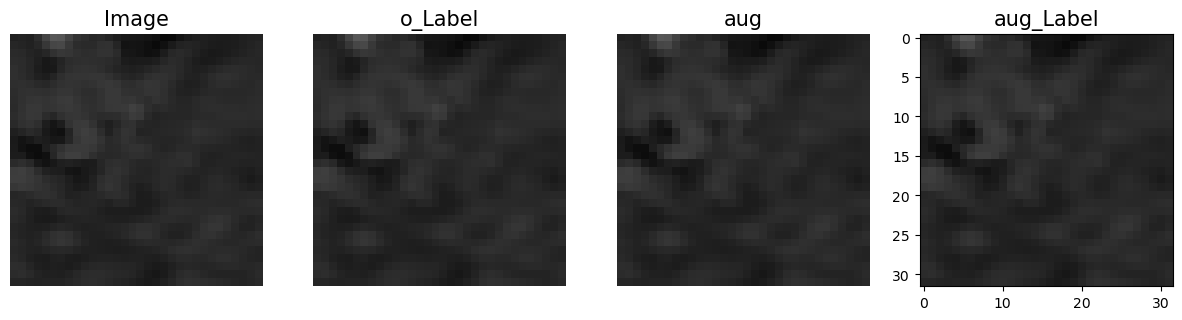

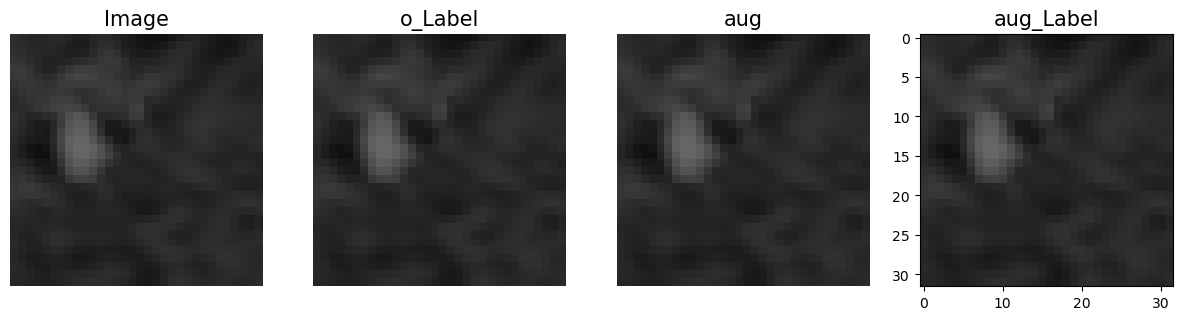

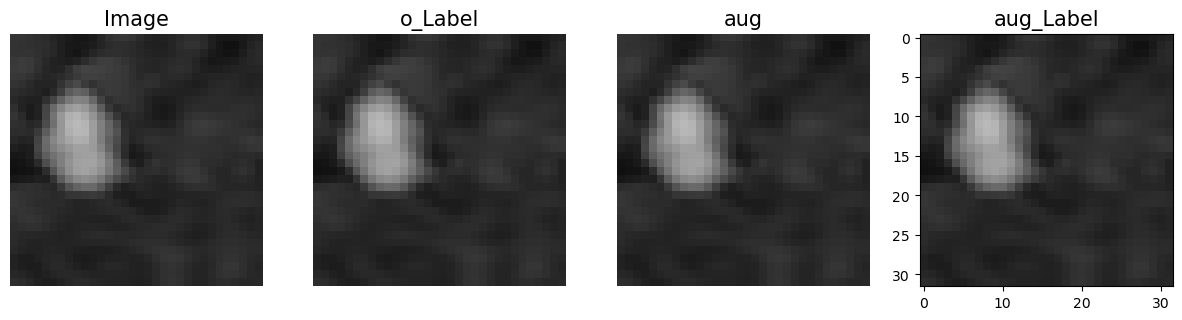

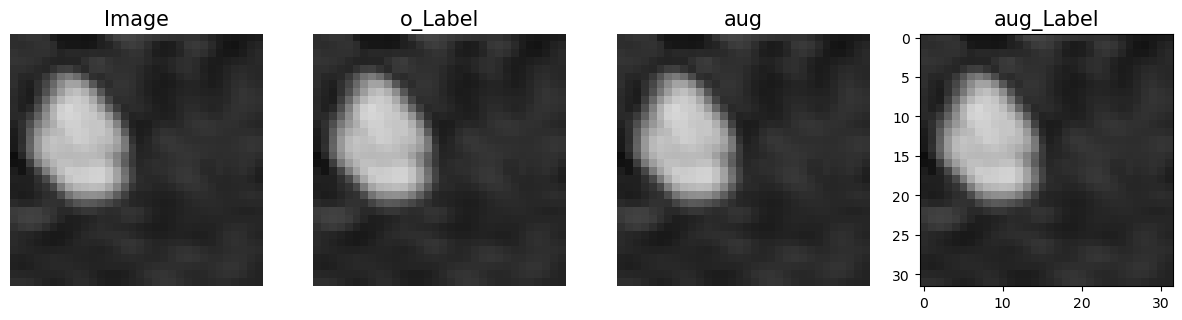

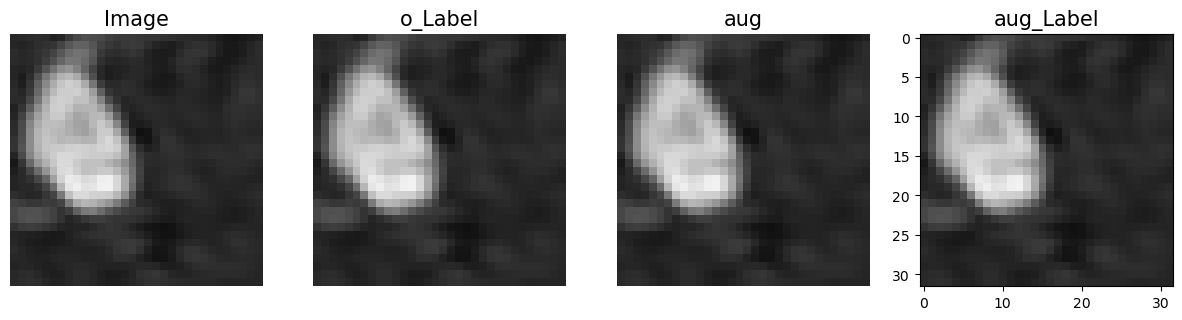

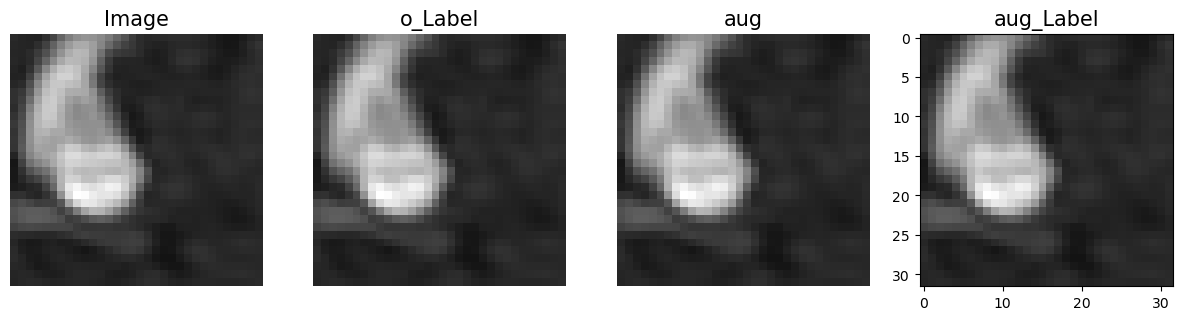

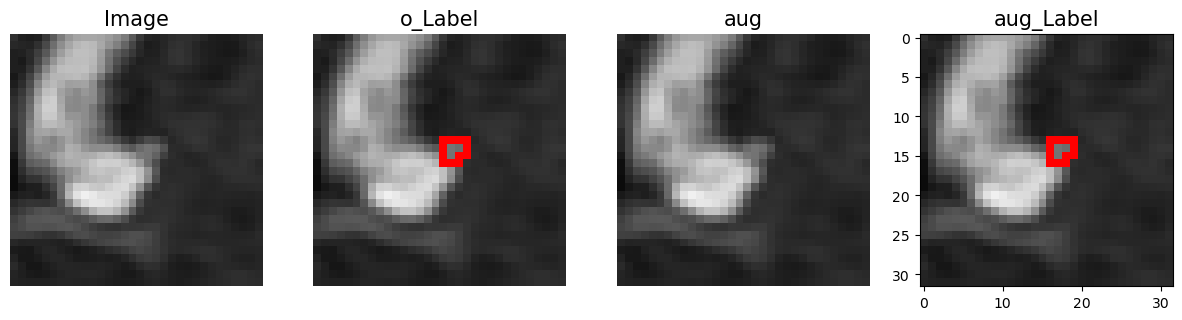

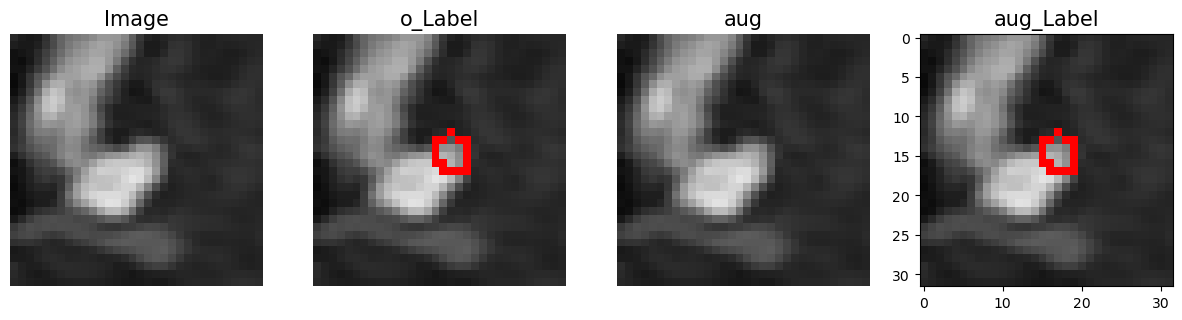

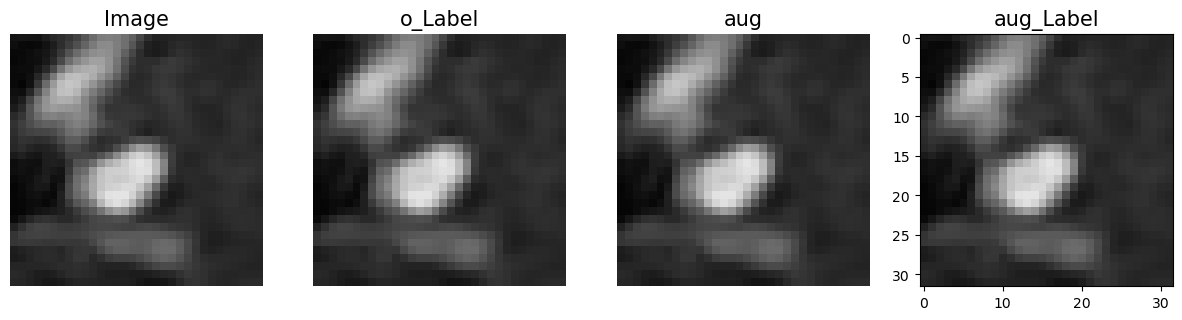

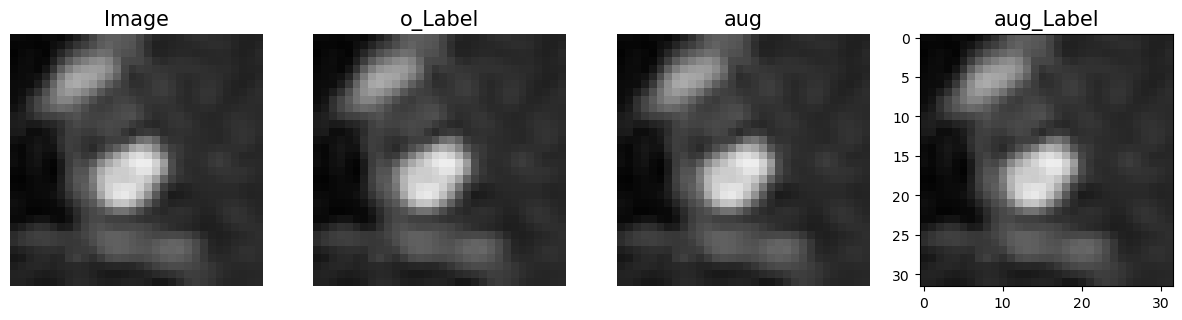

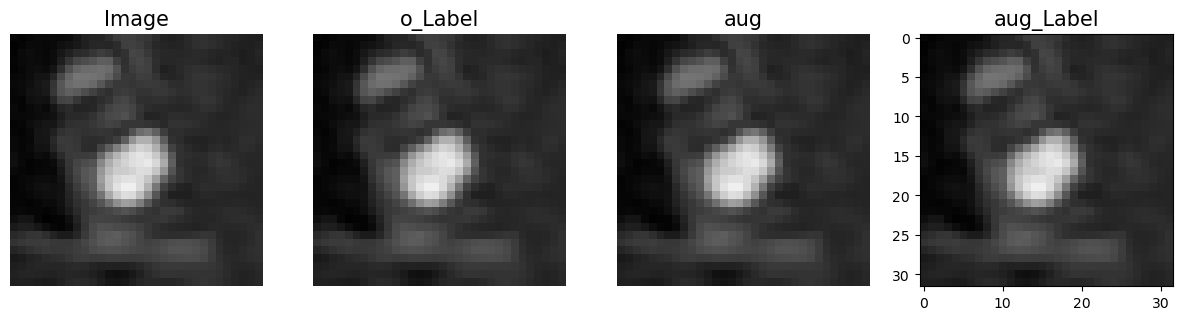

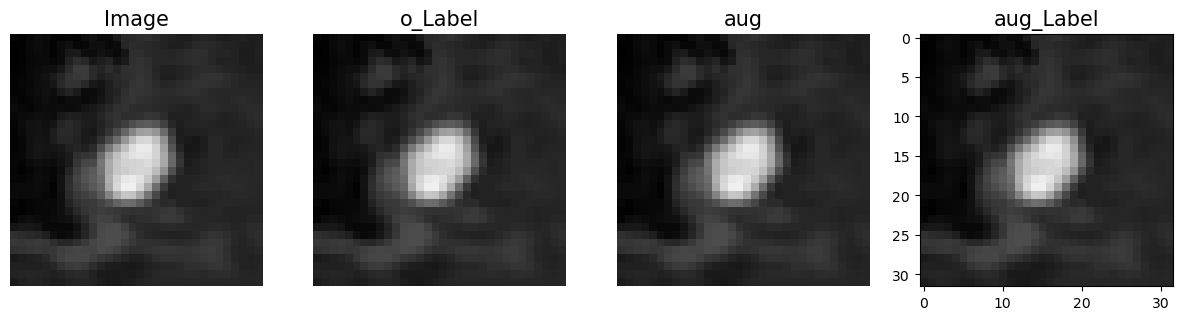

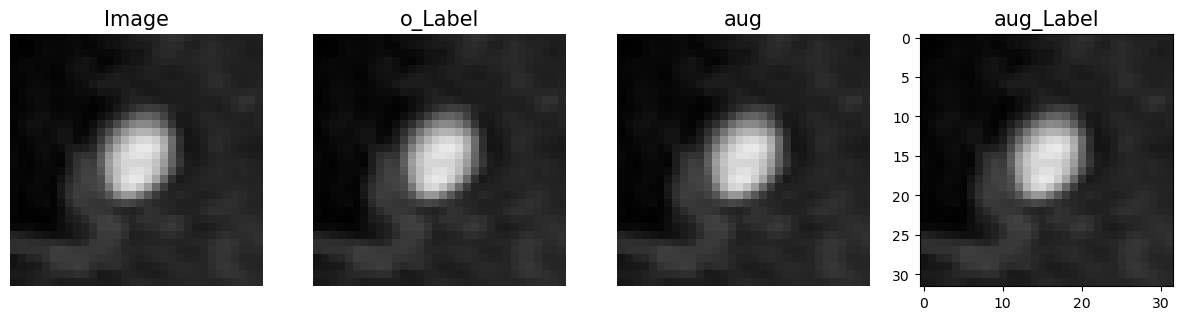

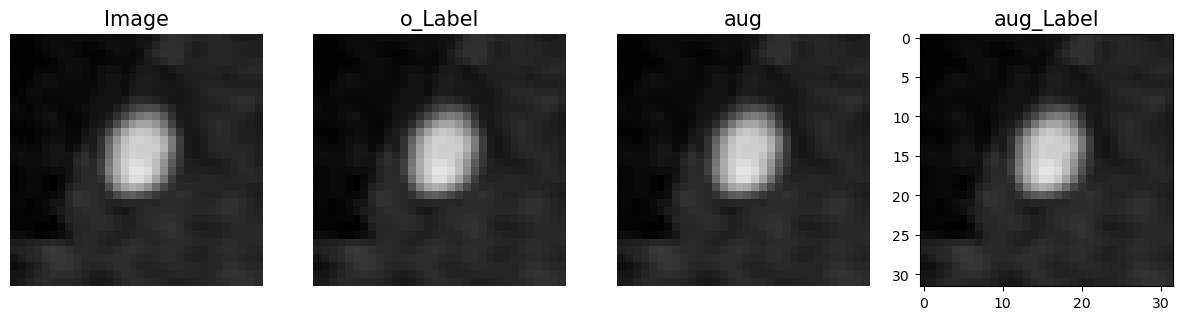

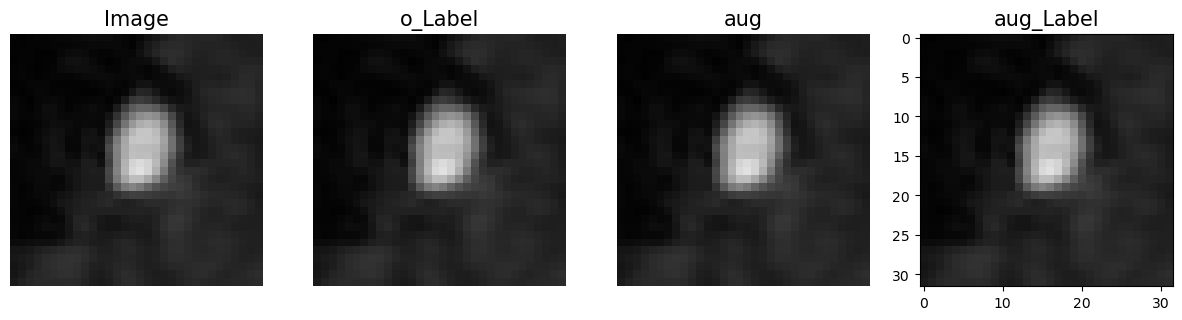

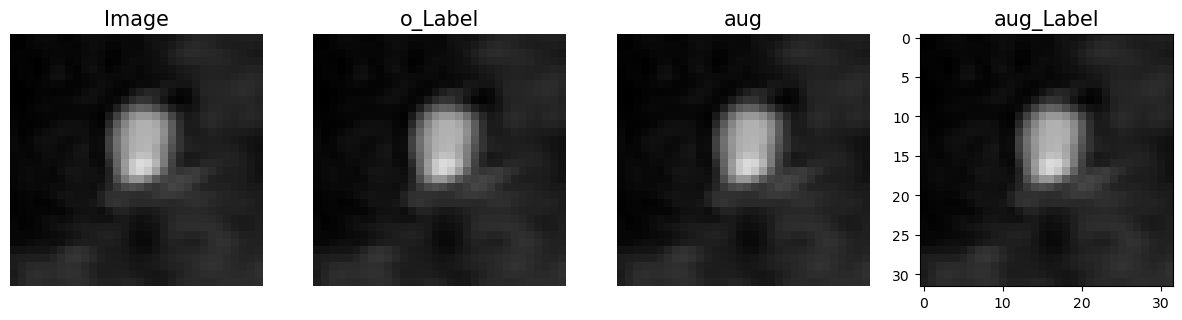

In [13]:
plot_multi_view2(a['data'], a['seg'], a['data'], a['seg'], -2)